<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Raleway:wght@100&display=swap" rel="stylesheet">

<h1 style="text-transform: uppercase; text-align: center; font-weight: 100;">
Linear regression in Tensorflow</h1>
<p style="text-align: center; font-weight: 100;">Predicting Volkswagen car prices</p><br/>

Project requirements:
- Only requirement is: minimum 10k rows
- Any type of neural network - classical but convolutional and recurrent, better grade
- Presentation of project, beside practical questions about model there would be also theoretical.
The topic is free.

Theory required for project presentation:
- Practical side.
- Discuss the scheme of an artificial neuron.
- Activation function, why it is so important.
- Explain how does neuron learn - steps, algorithm?
- How does basic neural network work? (The more you know the better, as well as more complex).
- Discuss the algorithm of neural network using backpropagation learning method. (metoda wstecznej propagacji błędów)
- What subsets and why are the data divided into?
Knowledge of ML, statistics.

Data source: data were taken from the popular Polish automotive website Otomoto (https://www.otomoto.pl/).

1. Import libraries and create dataframe:

In [153]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels as sm
import tensorflow as tf
# from model import VolkswagenModel
# from colorama import init, Fore, Style

print(f"np: {np.__version__}, pd: {pd.__version__}, tf: {tf.__version__}, mpl: {mpl.__version__}, sb: {sb.__version__}, sm: {sm.__version__}")
print("Libs loaded.")

data = pd.read_csv("./data/otomoto.csv")
df = pd.DataFrame(data)
df = df.drop(df.columns[0], axis=1)
df.columns = ['Price', 'Year', 'Mileage', 'Tank capacity', 'Fuel type', 'Model', 'Estimation']
print(data.dtypes)
df

np: 1.22.4, pd: 1.4.2, tf: 2.11.0, mpl: 3.7.1, sb: 0.12.2, sm: 0.13.5
Libs loaded.
Unnamed: 0       int64
Price            int64
Year             int64
Mileage          int64
Tank capacity    int64
Fuel type        int64
Model            int64
Estimation       int64
dtype: object


,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
2,364510,2022,5400,1968,7,8,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
...,...,...,...,...,...,...,...
14910,119500,2020,52000,1498,1,41,2
14911,31000,2002,511000,2461,7,9,0
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2


2. Clean data:

    Data was cleaned previously in 'scratchpad.py' file and now all the records are represented by integers(documentation of each column values is located in 'model.py' file). Values ​​of 0 represent an error in reading data. Column "Estimation" contains a lot of 0 values, but this is due to the fact that not every article on the website contained such information.

In [154]:
counter = 0
for index, row in df.iterrows():
    if row["Price"] == 0 or row["Year"] == 0 or row["Mileage"] == 0 or row["Tank capacity"] == 0 or row["Model"] == 0: 
        counter += 1
print(counter)

0


3. Price plot:

Lowest price value: 1500. Highest price value: 570000.


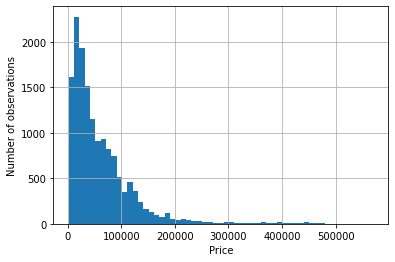

In [155]:
min = df["Price"].min()
max = df["Price"].max()
print(f"Lowest price value: {min}. Highest price value: {max}.")
price_plot = df["Price"].plot.hist(bins=57, grid=True)
price_plot.set_xlabel("Price")
price_plot.set_ylabel("Number of observations")
plt.show()

4. Year plot:

Lowest year value: 1958. Highest year value: 2023.


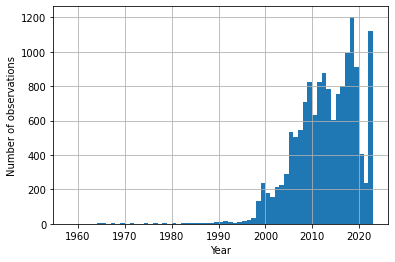

In [156]:
min = df["Year"].min()
max = df["Year"].max()
print(f"Lowest year value: {min}. Highest year value: {max}.")
year_plot = df["Year"].plot.hist(bins=(max-min), grid=True)
year_plot.set_xlabel("Year")
year_plot.set_ylabel("Number of observations")
plt.show()

5. Mileage plot:

Lowest mileage value: 1. Highest mileage value: 700000


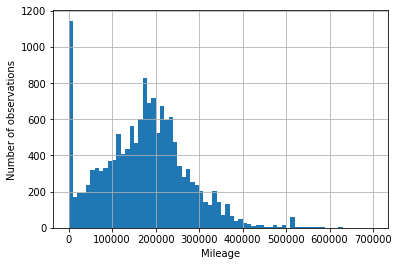

In [157]:
min = df["Mileage"].min()
max = df["Mileage"].max()
print(f"Lowest mileage value: {min}. Highest mileage value: {max}")
mileage_plot = df["Mileage"].plot.hist(bins=70, grid=True)
mileage_plot.set_xlabel("Mileage")
mileage_plot.set_ylabel("Number of observations")
plt.show()

6. Tank capacity plot:

Lowest tank capacity value: 77. Highest tank capacity value: 5998


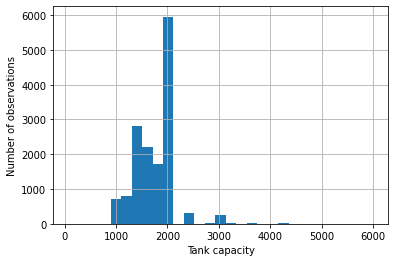

In [161]:
min = df["Tank capacity"].min()
max = df["Tank capacity"].max()
print(f"Lowest tank capacity value: {min}. Highest tank capacity value: {max}")
mileage_plot = df["Tank capacity"].plot.hist(bins=29,grid=True)
mileage_plot.set_xlabel("Tank capacity")
mileage_plot.set_ylabel("Number of observations")
plt.show()

# Trzeba jeszcze dopasować przedziały 

7. Fuel type plot:

8. Models plot:

9. Estimation plot: